# Predicting Procurement Compliance Using KPI-Driven Machine Learning Models

**Author:** Brittany Dowdle

**Date:** 7/13/2025

**Objective:** This notebook is part of the overall [capstone project](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone). The ultimate goal is to identify patterns and predictors of non-compliant suppliers using machine learning techniques.

## Introduction
This project uses the [Procurement KPI Analysis Dataset](https://www.kaggle.com/datasets/shahriarkabir/procurement-kpi-analysis-dataset) to predict compliance of suppliers. The dataset includes purchase order records from 5 different suppliers from 2022-2023. This notebook will be used to discover patterns, spot anomalies, test a hypothesis, and check assumptions to ensure the model will produce valid results.  

****

### Imports
In the code cell below are the necessary Python libraries for this notebook. *All imports should be at the top of the notebook.*

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

****
### 1. Load the Cleaned Dataset

In [26]:
# Load the dataset
df = pd.read_csv("C:/Users/Britt/Documents/44688/Dowdle_Analytics_Capstone/Data/cleaned_procurement_data.csv")

# Show the Dtypes of the features
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   po_id                       758 non-null    object 
 1   supplier                    758 non-null    object 
 2   order_date                  758 non-null    object 
 3   delivery_date               758 non-null    object 
 4   item_category               758 non-null    object 
 5   order_status                758 non-null    object 
 6   quantity                    758 non-null    int64  
 7   unit_price                  758 non-null    float64
 8   negotiated_price            758 non-null    float64
 9   defective_units             758 non-null    float64
 10  compliance                  758 non-null    object 
 11  lead_time_days              758 non-null    float64
 12  delivery_date_missing_flag  758 non-null    int64  
 13  price_diff                  758 non

### 2. Trend Line Charts

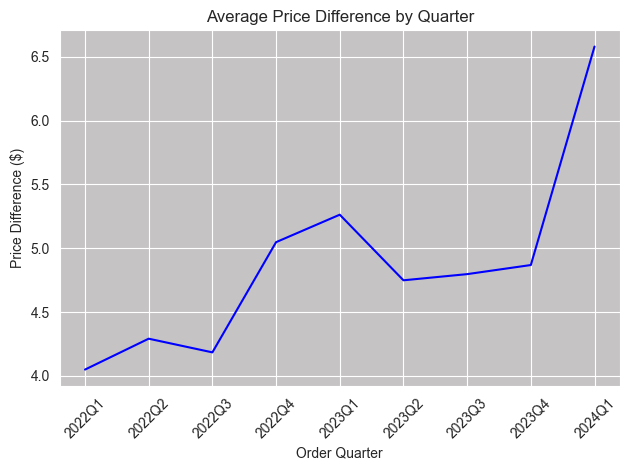

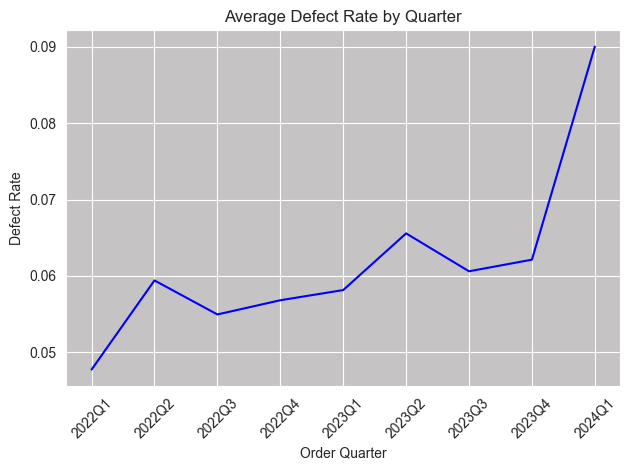

In [27]:
# Convert to datetime first (Should have been changed already from cleaning notebook)
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Create quarter based on order_date
df['order_quarter'] = df['order_date'].dt.to_period('Q')

# Quarterly average price_diff
price_diff_trend = df.groupby('order_quarter')['price_diff'].mean().reset_index()
price_diff_trend['order_quarter'] = price_diff_trend['order_quarter'].astype(str)

# Create style for both plots
sns.set_style("darkgrid", {"axes.facecolor": "#c5c3c3"})
# Create line chart
sns.lineplot(data=price_diff_trend, x='order_quarter', y='price_diff', color='blue')
# Create title and labels
plt.title("Average Price Difference by Quarter")
plt.xlabel("Order Quarter")
plt.ylabel("Price Difference ($)")
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

# Quarterly defect rate
defect_trend = df.groupby('order_quarter')['defect_rate'].mean().reset_index()
defect_trend['order_quarter'] = defect_trend['order_quarter'].astype(str)

# Create line chart
sns.lineplot(data=defect_trend, x='order_quarter', y='defect_rate', color='blue')
# Create title and labels
plt.title("Average Defect Rate by Quarter")
plt.xlabel("Order Quarter")
plt.ylabel("Defect Rate")
plt.xticks(rotation=45)
# Show the plot
plt.tight_layout()
plt.show()

### 3. Numerical Column Distributions

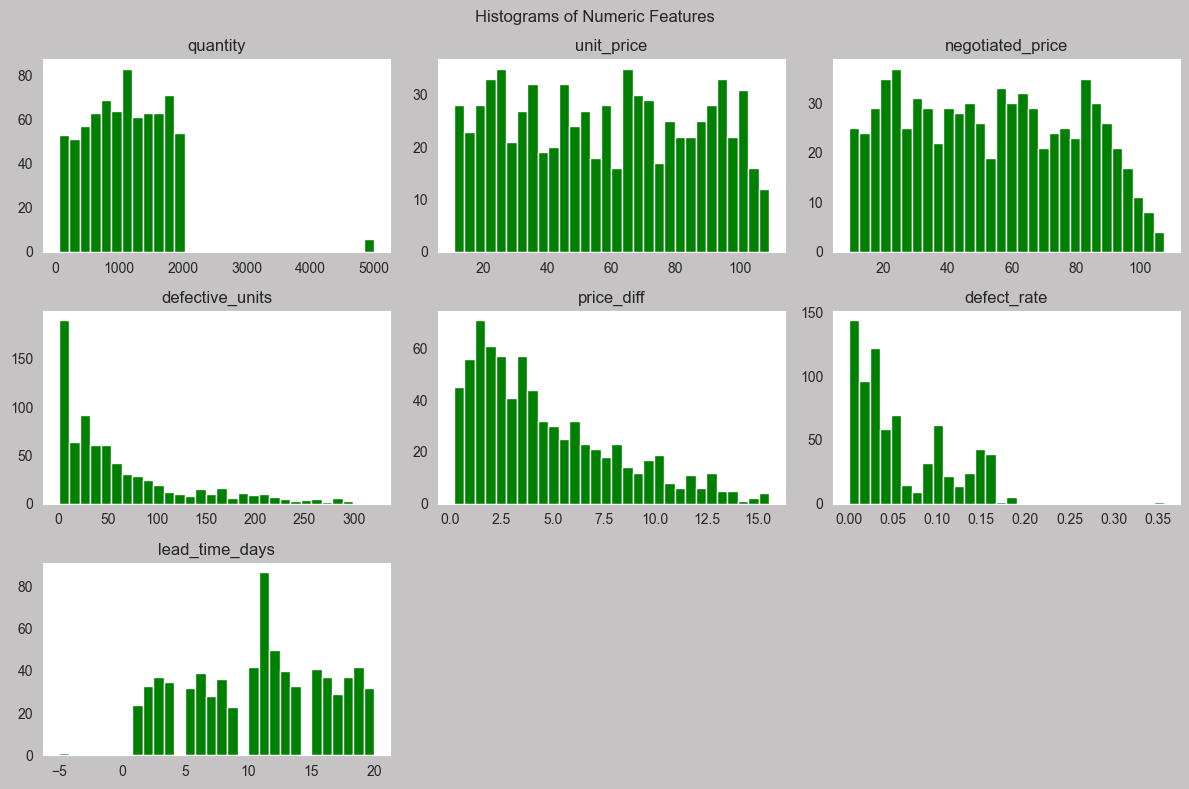

In [34]:
# Define feature for all numeric columns
numeric_cols = ['quantity', 'unit_price', 'negotiated_price', 'defective_units', 'price_diff', 'defect_rate', 'lead_time_days']

# Create figure for plot
fig = df[numeric_cols].hist(bins=30, figsize=(12, 8), color='green', grid=False)
fig[0][0].figure.set_facecolor("#c5c3c3")
# Create histograms
sns.set_style({"axes.facecolor": 'white'})
plt.suptitle("Histograms of Numeric Features")
# Show the plot
plt.tight_layout()
plt.show()

### 4. Categorical Column Distributions

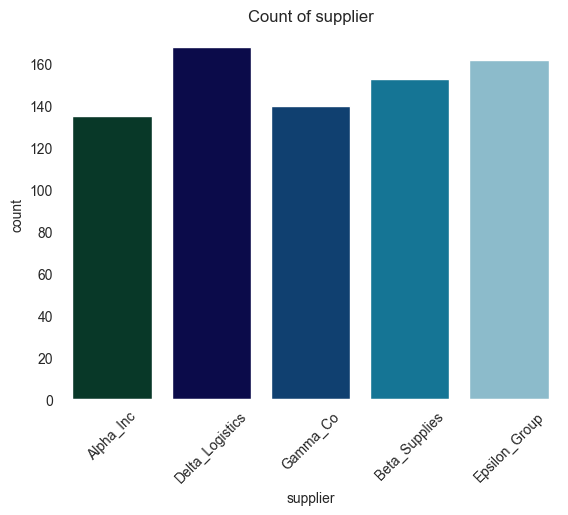

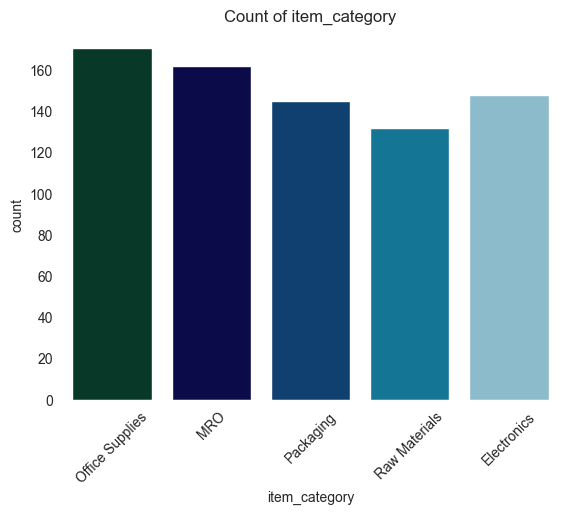

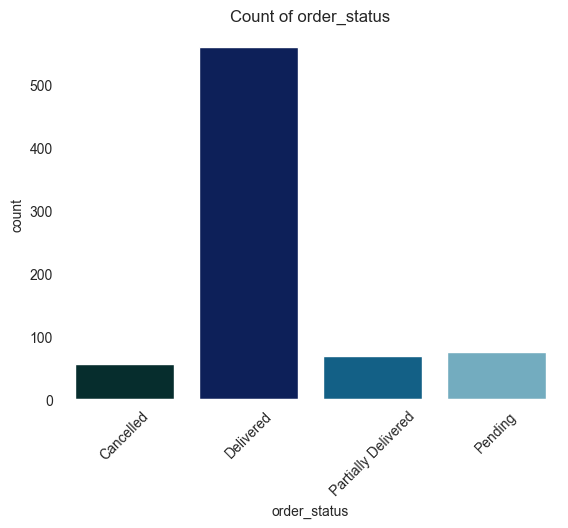

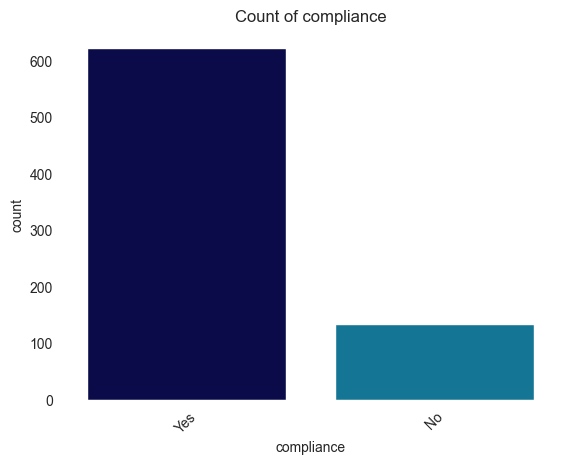

In [29]:
# Create feature for all categorical columns
categorical_cols = ['supplier', 'item_category', 'order_status', 'compliance']

# Create the plots
for col in categorical_cols:
    sns.countplot(x=df[col], hue=df[col], palette='ocean', data=df)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    # Show the plots
    plt.show()

Verify class imbalance to consider how it should be handled later in modeling. 

In [30]:
# A balanced dataset is usually within 10%
df['compliance'].value_counts(normalize=True)

compliance
Yes    0.8219
No     0.1781
Name: proportion, dtype: float64

### 5. Correlation Matrix

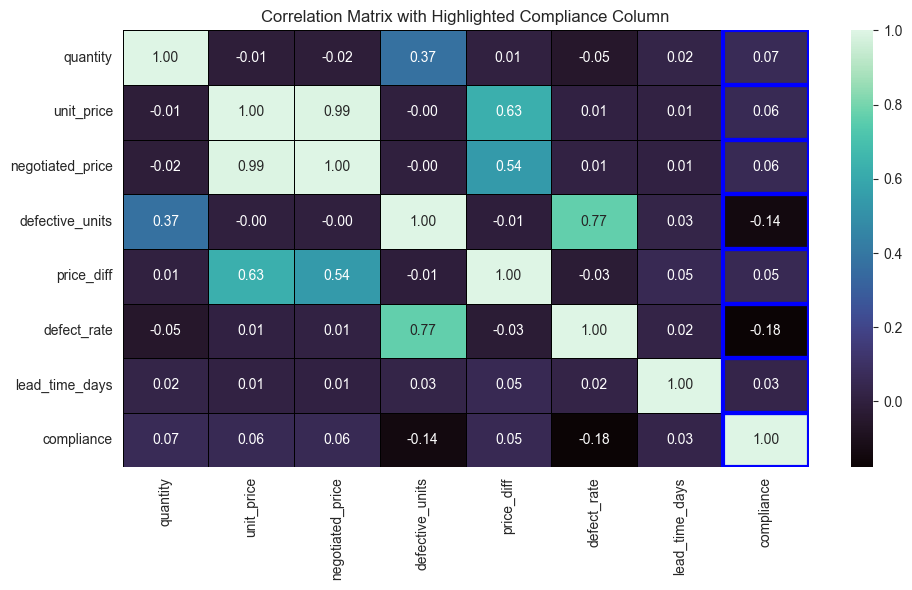

In [31]:
# Use only numeric columns to determine correlation
df['compliance'] = df['compliance'].map({'Yes': 1, 'No': 0})
correlation = df[numeric_cols + ['compliance']].corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(correlation, annot=True, cmap='mako', fmt='.2f', cbar=True, linewidths=0.5, linecolor='black')

# Get index of compliance column
comp_idx = correlation.columns.get_loc('compliance')

# Highlight the compliance column cells with a colored rectangle
for row in range(correlation.shape[0]):
    # Rectangle parameters: (x, y), width, height
    rect = patches.Rectangle(
        (comp_idx, row), 1, 1, fill=False, edgecolor='Blue', linewidth=3
    )
    ax.add_patch(rect)

plt.title("Correlation Matrix with Highlighted Compliance Column")
# Show the plot
plt.tight_layout()
plt.show()

Distributions by compliance for strong predictive features.

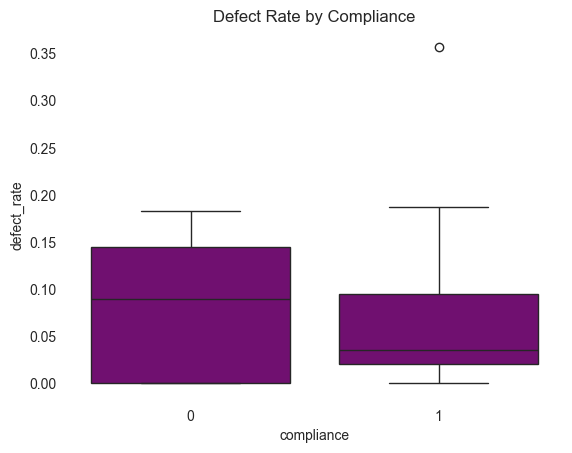

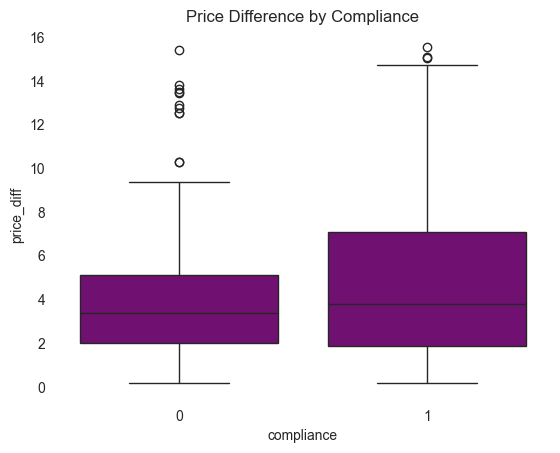

In [32]:
# Create the boxplot
sns.boxplot(data=df, x='compliance', y='defect_rate', color='purple')
# Create the title
plt.title("Defect Rate by Compliance")
# Show the plot
plt.show()

# Create the boxplot
sns.boxplot(data=df, x='compliance', y='price_diff', color='purple')
# Create the title
plt.title("Price Difference by Compliance")
# Show the plot
plt.show()

### 6. Vendor Comparisons

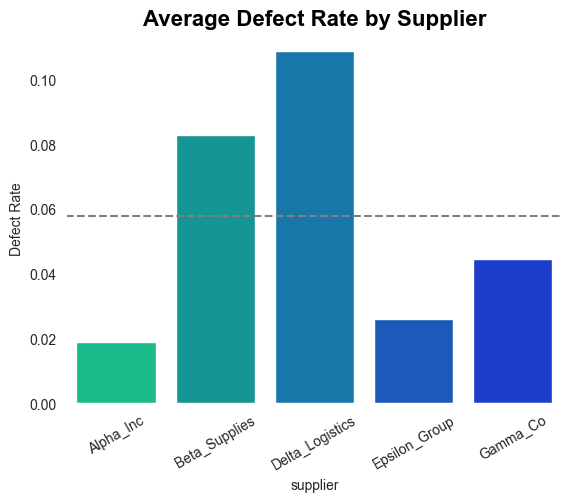

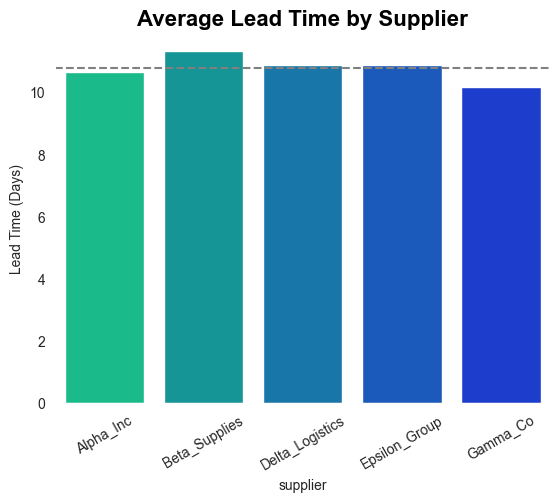

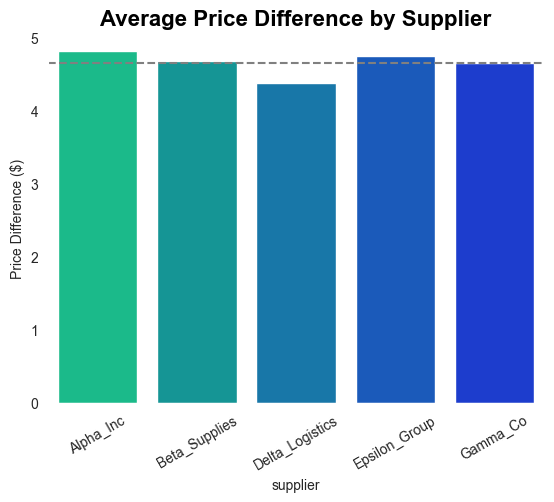

In [33]:
# Compare average defect rate, lead time, and price_diff by supplier
supplier_perf = df.groupby('supplier')[['defect_rate', 'lead_time_days', 'price_diff']].mean().reset_index()

# Create the bar plot
sns.barplot(data=supplier_perf, x='supplier', y='defect_rate', hue='supplier', palette='winter_r')
# Create title and labels
plt.title("Average Defect Rate by Supplier", fontsize=16, fontweight='bold', color='black')
plt.ylabel("Defect Rate")
# Create baseline for average 
mean_defect_rate = df['defect_rate'].mean()
plt.axhline(mean_defect_rate, color='gray', linestyle='--', linewidth=1.5)
plt.xticks(rotation=30)
# Show the plot
plt.show()

# Create the bar plot
sns.barplot(data=supplier_perf, x='supplier', y='lead_time_days', hue='supplier', palette='winter_r')
# Create title and labels
plt.title("Average Lead Time by Supplier", fontsize=16, fontweight='bold', color='black')
plt.ylabel("Lead Time (Days)")
# Create baseline for average
mean_lead_days = df['lead_time_days'].mean()
plt.axhline(mean_lead_days, color='gray', linestyle='--', linewidth=1.5)
plt.xticks(rotation=30)
# Show the plot
plt.show()

# Create bar plot
sns.barplot(data=supplier_perf, x='supplier', y='price_diff', hue='supplier', palette='winter_r')
# Create title and labels
plt.title("Average Price Difference by Supplier", fontsize=16, fontweight='bold', color='black')
plt.ylabel("Price Difference ($)")
# Create baseline for average
mean_price_diff = df['price_diff'].mean()
plt.axhline(mean_price_diff, color='gray', linestyle='--', linewidth=1.5)
plt.xticks(rotation=30)
# Show the plot
plt.show()

****
### Conclusion
Among the numerical features defect_rate demonstrated the strongest negative correlation with compliance. This suggests that quality-related metrics are critical indicators. Supplier trends also revealed variation in performance. Some vendors consistently underperformed on KPIs. These insights provide a strong foundation for developing predictive models that classify compliance based on order characteristics. 

****
### Conclusion